# CS146 Final Project
## Prof. Scheffler
### Anirudh Nair


In [113]:
#importing the required libraries
import pystan
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as sts
from scipy.optimize import curve_fit
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import adfuller
from datetime import datetime,timedelta
sns.set()

font = {'family' : 'Georgia',
        'weight' : 'bold',
        'size'   : 25}

matplotlib.rc('font', **font)

# Data Loading and Preprocessing
Process the time column,subtract the min value from the array, so the first recording has value 0, and divide the entire array by (365.25*4 = 1461 days = 4 years), so each unit is 4 years(this leads to large parameter values and better Stan inference results)

In [158]:
#importing the data from the given dataset
data = pd.read_csv('/Users/anirudhn/Desktop/Code/CS146_Assignments/Final_Project/weekly_in_situ_co2_mlo (1).csv',names=['Dates','CO2'], skiprows=44)

In [161]:
#preprocessing the data by storing the date values relative to the first instance of data collection
firstdate = data['Dates'][0]
data['Dates'] = data.apply(lambda x:(abs((datetime.strptime(firstdate, "%Y-%m-%d") - datetime.strptime(x['Dates'], "%Y-%m-%d")).days))/1461, axis = 1)

In [196]:
type(data['Dates'][0])

numpy.float64

# Plotting the Preprocessed data

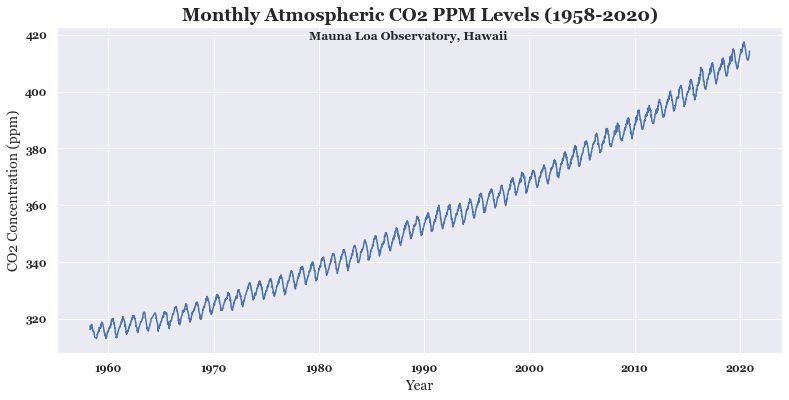

In [181]:
#plot for the data acquired

plt.figure(figsize=(13,6))
plt.plot(data['Dates']*4+1958.25, data['CO2'])
plt.xlabel('Year', fontsize=14)
plt.ylabel('CO2 Concentration (ppm)', fontsize=14)
plt.title('Monthly Atmospheric CO2 PPM Levels (1958-2020)', fontsize=18, weight='semibold')
plt.figtext(.5,.85,'Mauna Loa Observatory, Hawaii', fontsize=12, ha='center')
plt.show()

# Linear Model (From the Example)
We begin by executing the most basic possible model to have a starting ground from where we can expand upon based on the shortcomings we notice. Hence, 

In [219]:
#compiling the input data that will be fed into all stan models hereon
length = len(data['CO2'].values)
co2 = list(data['CO2'])
dates = list(data['Dates'])
stan_data = {
                'N': length, 
                'co2S': co2,
                'dayS': dates
            }

In [224]:

linear_model_stan = """

data {  
    // length of the data collected
    int<lower=1> N;           
    
    // the data
    real<lower=0> co2S[N]; 
    real<lower=0> dayS[N];
}

parameters {
    // noise
    real sigma;   
    
    //long erm trend parameters
    real<lower=0> c_0;
    real<lower=0> c_1;
    
    //seasonal variation parameters (amplitudes)
    real<lower=0> c_2;
    real<lower=0> c_3;
    
    //phases
    real<lower=0,upper=1> phi_1;
    real<lower=0,upper=1> phi_2;
}

model {
    sigma ~ normal(0, 1);      //generate random noise from normal distribution
    
    //priors for the different parameters of our model
    c_0 ~ cauchy(0,0.1);       
    c_1 ~ cauchy(0,1);
    
    c_2 ~ cauchy(0,1);
    c_3 ~ cauchy(0,1);
    
    phi_1 ~ cauchy(0,1);
    phi_2 ~ cauchy(0,1);
    
    for(i in 1:N) {
        co2S[i] ~ normal(c_0 + c_1*dayS[i] + c_2*cos((2*pi()*dayS[i])/365.25 + phi_1) + c_3*cos((2*pi()*dayS[i])/15000 + phi_2), sigma); //likelihood function from the example
  };
}

"""
linear_model = pystan.StanModel(model_code=linear_model_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_507cc1c0b20e2f53ef301e0e7b19c245 NOW.


In [223]:
linear_model_results= linear_model.sampling(data=stan_data)
print(linear_model_results)

KeyboardInterrupt: 